In [ ]:
from pycbc.waveform import td_approximants,fd_approximants
print("pycbc中可用的时间域TD:",td_approximants())
print("-------------------")
# 
print("pycbc中可用的频率域FD",fd_approximants())

pycbc中可用的时间域TD: ['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'SEOBNRv4HM_PA', 'pSEOBNRv4HM_PA', 'IMRPhenomXAS_NRTidalv2', 'IMRPhenomXP_NRTidalv2', 'IM

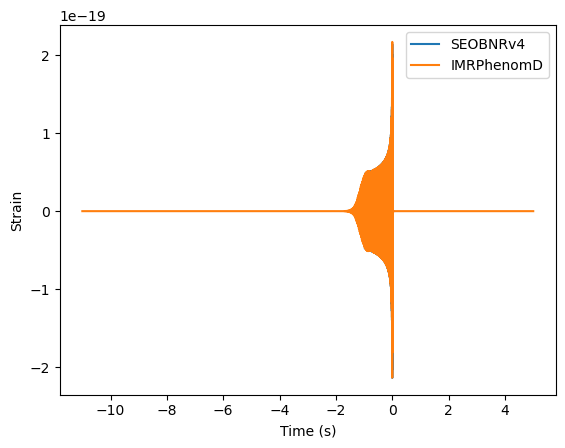

In [ ]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform

# SEOBMRv4和IMRPhenomD分别是两种近似模型
for apx in ['SEOBNRv4', 'IMRPhenomD']:
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=10, # 第一个天体质量
                                 mass2=10, # 第二个天体质量
                                 spin1z=0.9, # 天体自选参数
                                 delta_t=1.0/4096, # 时间间隔
                                 f_lower=40) # 最低频率
# hp.sample_times是时间
    pp.plot(hp.sample_times, hp, label=apx)

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()